In [3]:
import os
from functools import partial
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import tf_logging as logging

import data_utils
import tensorflow_model

import matplotlib.image as mpimg

%matplotlib inline

logging.set_verbosity(logging.INFO)
logging.log(logging.INFO, "Tensorflow version " + tf.__version__)

INFO:tensorflow:Tensorflow version 1.13.1


In [4]:
num_classes = 10

labels = {"airplane.png": 0,
          "automobile.png": 1,
          "bird.png": 2,
          "cat.png": 3,
          "deer.png": 4,
          "dog.png": 5,
          "frog.png": 6,
          "horse.png": 7,
          "ship.png": 8,
          "truck.png": 9}

class_maping = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


# this is where you put your dataset
bas_dir = "/home/andrew/Keras_to_estimator/dataset"

predict_dir = join(bas_dir, "test")

# this is where you put tfrecords
tfrecord_path = "/home/andrew/Keras_to_estimator/data"

In [5]:
model = tensorflow_model.cnn_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

model_input_name = model.input_names[0]
print(f"model_input_name: {model_input_name}")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
model_input_name: input_1


In [6]:
def getFileList(dir):
    x = []
    y = []
    for f in os.listdir(dir):
        path = join(dir, f)
        if os.path.isfile(path):
            y.append(labels.get(f.split("_")[1]))
            x.append(path)
    return x, y


def prediction_data(predict_dir):
    predict_image, true_labels = getFileList(predict_dir)
    return predict_image[1:45], true_labels[1:45]


def _parse_function(filename):
    # you can change your parsing function with more data augmentation
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_decoded = tf.image.convert_image_dtype(image_decoded, tf.float32)
    image_decoded = image_decoded
    image_decoded.set_shape([32, 32, 3])
    # input_3 is from your model. if error, change it accordingly
    return {model_input_name: image_decoded}


def predict_input_fn(image_path):
    img_filenames = tf.constant(image_path)

    dataset = tf.data.Dataset.from_tensor_slices(img_filenames)
    dataset = dataset.map(_parse_function)
    dataset = dataset.repeat(1)
    dataset = dataset.batch(32)
    iterator = dataset.make_one_shot_iterator()
    image = iterator.get_next()

    return image

In [9]:
cifar_est = tf.keras.estimator.model_to_estimator(keras_model=model, model_dir="train")

train_data = os.path.join(tfrecord_path, "train.tfrecords")
train_input = lambda: data_utils.dataset_input_fn(train_data, None)
cifar_est.train(input_fn=train_input, steps=7000)

test_data = os.path.join(tfrecord_path, "test.tfrecords")
test_input = lambda: data_utils.dataset_input_fn(test_data, 1)
res = cifar_est.evaluate(input_fn=test_input, steps=1)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': 'train', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8ae47b7da0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting w

INFO:tensorflow:Warm-starting variable: training/Adam/Variable_52; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: training/Adam/Variable_53; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: training/Adam/Variable_54; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: training/Adam/Variable_55; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: training/Adam/Variable_56; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: training/Adam/Variable_57; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: training/Adam/Variable_58; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: training/Adam/Variable_59; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from train/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 

INFO:tensorflow:Starting evaluation at 2019-08-13T10:16:55Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from train/model.ckpt-7000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-08-13-10:16:56
INFO:tensorflow:Saving dict for global step 7000: categorical_accuracy = 0.875, global_step = 7000, loss = 0.3353895
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7000: train/model.ckpt-7000


In [10]:
acc = res["categorical_accuracy"]
loss = res["loss"]

print(f"Accuracy = {acc}\tLoss = {loss}")

Accuracy = 0.875	Loss = 0.33538949489593506


In [11]:
# this is for serving, will produce a pb file for deployment
def serving_input_receiver_fn():
    input_ph = tf.placeholder(tf.string, shape=[None], name='image_binary')
    images = tf.map_fn(partial(tf.image.decode_image, channels=1), input_ph, dtype=tf.uint8)
    images = tf.cast(images, tf.float32) / 255.
    images.set_shape([None, 32, 32, 3])

    return tf.estimator.export.ServingInputReceiver({model_input_name: images}, {'bytes': input_ph})

export_path = cifar_est.export_savedmodel('./export_train', serving_input_receiver_fn=serving_input_receiver_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from train/model.ckpt-7000
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./export_train/temp-b'1565691423'/saved_model.pb


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from train/model.ckpt-7000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


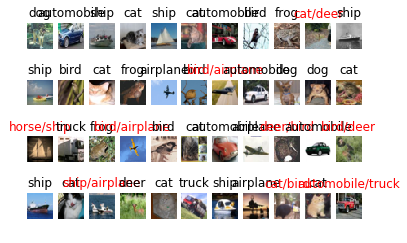

Test accuracy: 79.54545454545455%


In [12]:
# this is prediction phase
predict_image, true_label = prediction_data(predict_dir)

# number of predictions, supposed to be 45 by default
nPreds = len(true_label)

predict_result = list(cifar_est.predict(input_fn=lambda: predict_input_fn(predict_image)))

pos = 1
wrong = 0
for img, lbl, predict_lbl in zip(predict_image, true_label, predict_result):
    output = np.argmax(predict_lbl.get('output'), axis=None)
    plt.subplot(4, 11, pos)
    img = mpimg.imread(img)
    plt.imshow(img)
    plt.axis('off')
    if output == lbl:
        plt.title(class_maping[output])
    else:
        wrong += 1
        plt.title(class_maping[output] + "/" + class_maping[lbl], color='#ff0000')
    pos += 1

plt.show()

test_acc = (1 - wrong / nPreds) * 100
print(f"Test accuracy: {test_acc}%")